In [2]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

df = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/CLA_RF_input.csv')
df.head()

,FSM,SMC,Disabled?,White_British?,Number_contacts,Number_referrals,Number_assessments,Number_strategies,Number_S47s,Number_ICPCs,Number_CIN_plans,Number_CP_plans,CLA
0,0,0,1,1,0,5,0,1,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0


In [3]:
# feature_cols = ['FSM', 
#                 'SMC', 
#                 'Disabled?', 
#                 'White_British?',
#                 'Number_contacts',
#                 'Number_referrals',
#                 'Number_assessments',
#                 'Number_strategies',
#                 'Number_S47s',
#                 'Number_ICPCs',
#                 'Number_CIN_plans',
#                 'Number_CP_plans',]
X = df.drop('CLA', axis=1)
y = df['CLA'] # Target variable

In [4]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

rf = RandomForestClassifier() # No arguments until we're ready to tune hyperparameters

# Train the classifier on the training data
rf = rf.fit(X_train, y_train)

# Check how well the classifier fits the test data
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)



Accuracy:  0.9686793824370664


In [5]:
# Tuning hyperparameters
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0862b9dea0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0862b9c0d0>})

In [6]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 199}


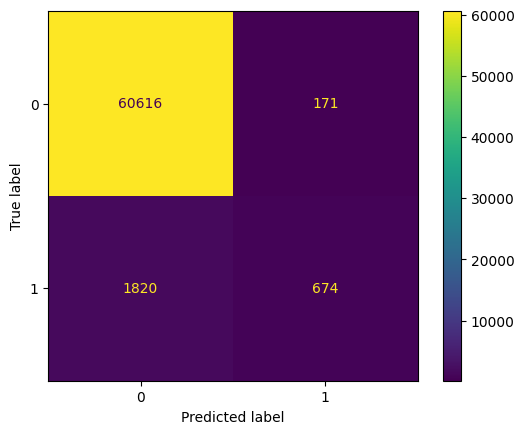

In [7]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();